In [32]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [33]:
train_path = 'TRAINDATAnewcols7.19_3year.csv'
test_path = 'TESTDATAnewcols7.19_3year.csv'
predict_path = 'PREDICTDATAnewcols7.19_3year.csv'
lower_alpha_bound = 0
upper_alpha_bound = 100
alpha_iterations = 100
max_iters=1000

In [34]:
def run_lasso_model_scaled(train_path, test_path, predict_path, alpha_lower_bound=0, 
                           alpha_upper_bound=100, alpha_iterations=101, max_iterations=1000, 
                           log_y='No', current_rent='No', PCA_data='No'):
    '''
    Function to run the lasso regression model on our data for the capstone project.
    Need to enter in the path to the data, and then have optional arguments you can enter.
    
    Inputs:
    train_path - name of the training data file, in quotes as a text string.
    test_path - name of the testing data file, in quotes as a text string.
    alpha_lower_bound - lower end of the penalization hyperparameter for the lasso regression. Defaults to 0
    alpha_upper_bound - upper end of the penalization hyperparameter for the lasso regression. Defaults to 100
    alpha_iterations - number of values used in the previously specified range for alpha. Defaults to 101
    max_iterations - maximum iterations for the lasso regression. Defaults to 1,000.
    '''
    # Load the data
    data = pd.read_csv(train_path, index_col=False)
    test_data = pd.read_csv(test_path, index_col=False)
    predict_data = pd.read_csv(predict_path, index_col=False)

    
    # Create X and y for machine learning    
    drop_list = ['Rent', 'RegionName', 'City', 'State']
    if current_rent in ['No', 'no', 0]:
        drop_list.append('Current Rent')
    if PCA_data in ['Yes', 'yes', 1]:
        drop_list = ['Rent']         

    train_X = data.drop(drop_list, axis=1)
    test_X = test_data.drop(drop_list, axis=1)
    predict_X = predict_data.drop(drop_list, axis=1)
    
    
    print('value of log_y:', log_y)
    
    if log_y in ['No', 'no', 0]:
        train_y = data['Rent']
        test_y = test_data['Rent']
        predict_y = predict_data['Rent']
    elif log_y in ['Yes', 'yes', 1]:
        train_y = np.log(data['Rent'])
        test_y = np.log(test_data['Rent'])
        predict_y = np.log(predict_data['Rent'])
    else:
        raise ValueError('Enter Yes or No for log_y parameter')
    
    
    ## SCALE DATA ## 
    if PCA_data in ['Yes', 'yes', 1]:
        train_X_scaled = train_X.copy()
        test_X_scaled = test_X.copy()
        predict_X_scaled = predict_X.copy()
    else:
        scaler = StandardScaler().fit(train_X)
        train_X_scaled = scaler.transform(train_X)
        test_X_scaled = scaler.transform(test_X)
        predict_X_scaled = scaler.transform(predict_X)
    
    # Create and fit the model
    lasso = Lasso(normalize=False, max_iter=max_iterations)
    lasso_params = {'alpha':np.linspace(alpha_lower_bound,alpha_upper_bound,alpha_iterations)}
    grid_lasso = GridSearchCV(lasso, lasso_params, scoring='r2', n_jobs=-1, cv=5, verbose=2)
    grid_lasso.fit(train_X_scaled, train_y)
    
    # Tell user alpha used
    print('Best alpha: ', grid_lasso.best_params_['alpha'])
    
    # Tell user training score
    print('Score on training data: ', round(grid_lasso.score(train_X_scaled,train_y),3))
    
    # Tell user the cross-validation scores
    print('Scores from 5-fold cross-validation: \n', cross_val_score(grid_lasso, train_X_scaled, train_y, scoring='r2', n_jobs=-1, cv=5))
    
    # Tell user the test score (for zip codes not seen)
    print('Score on TEST data (zip codes not trained on): ', round(grid_lasso.score(test_X_scaled,test_y),3))
    
    # Tell the user the Prediction score (for future years not seen)
    print('Score on PREDICT data (years not trained on): ', round(grid_lasso.score(predict_X_scaled,predict_y),3))
    
    # RMSE for prediction
    print('RMSE for PREDICT data: ', mean_squared_error(predict_y, grid_lasso.predict(predict_X_scaled), squared=False))
    
    # Get coefs for best model
    best_mod = Lasso(alpha=grid_lasso.best_params_['alpha'], max_iter = max_iterations)
    best_mod.fit(train_X_scaled, train_y)
    coef_list = list(zip(list(train_X.columns), best_mod.coef_))
    print('Total features: ', len(coef_list))
    used_list = []
    for x in coef_list:
        if x[1] != 0:
            used_list.append(x)
    print('Number of Features used: ', len(used_list), '\n')
    print('Used Features, sorted by importance:')
    for x in sorted(used_list, key=lambda x: abs(x[1]), reverse=True):
        print(x)
    
    # Return multicollinearity chart
    feature_names = [x[0] for x in used_list]
    RSquared = []
    variable_name = []
    for var in feature_names:
        dep_var = StandardScaler().fit_transform(np.array(train_X[var]).reshape(-1,1))
        predictors =StandardScaler().fit_transform(train_X.drop(var, axis=1))
        ols = LinearRegression()
        ols.fit(predictors, dep_var)
        variable_name.append(var)
        RSquared.append(ols.score(predictors, dep_var))

    val_dfs = pd.concat([pd.Series(RSquared), pd.Series(variable_name)], axis=1)
    val_dfs = val_dfs.sort_values(by=0, ascending=False)

    # Print multicollinearity info
    print('\nMulticollinearity tests for used variables:\n', val_dfs)    
    
    ## Plotting multicollinearity test from previous project ##
    plt.rcParams["figure.figsize"] = (30,3)
    plt.plot(val_dfs[1], val_dfs[0])
    plt.xticks(rotation=90)
    plt.ylim(0,1)

    plt.show()
    

value of log_y: False
Fitting 5 folds for each of 101 candidates, totalling 505 fits
Best alpha:  1.44
Score on training data:  0.762
Scores from 5-fold cross-validation: 
 [0.69226187 0.73616301 0.73452103 0.72899253 0.80325943]
Score on TEST data (zip codes not trained on):  0.69
Score on PREDICT data (years not trained on):  0.741
RMSE for PREDICT data:  341.2131742263677
Total features:  33
Number of Features used:  30 

Used Features, sorted by importance:
('renter_occupied_units_perc', 435.7842041892331)
('median_income', 406.21502022727594)
('average_car_per_household', 319.60573706287107)
('housing_per_pop', -299.82663137704674)
('walk_to_work_perc', 258.77107291494303)
('Perc_commuter_by_public_transport', 213.7285492309589)
('Perc_vacat_housing_units', 205.3758376763473)
('median_age', 198.58916291935316)
('married_households_perc', -117.5342068455243)
('Perc_different_house_year_ago_same_city', -116.194161236739)
('Perc_different_house_year_ago_dif_city', -109.68213846533)
(

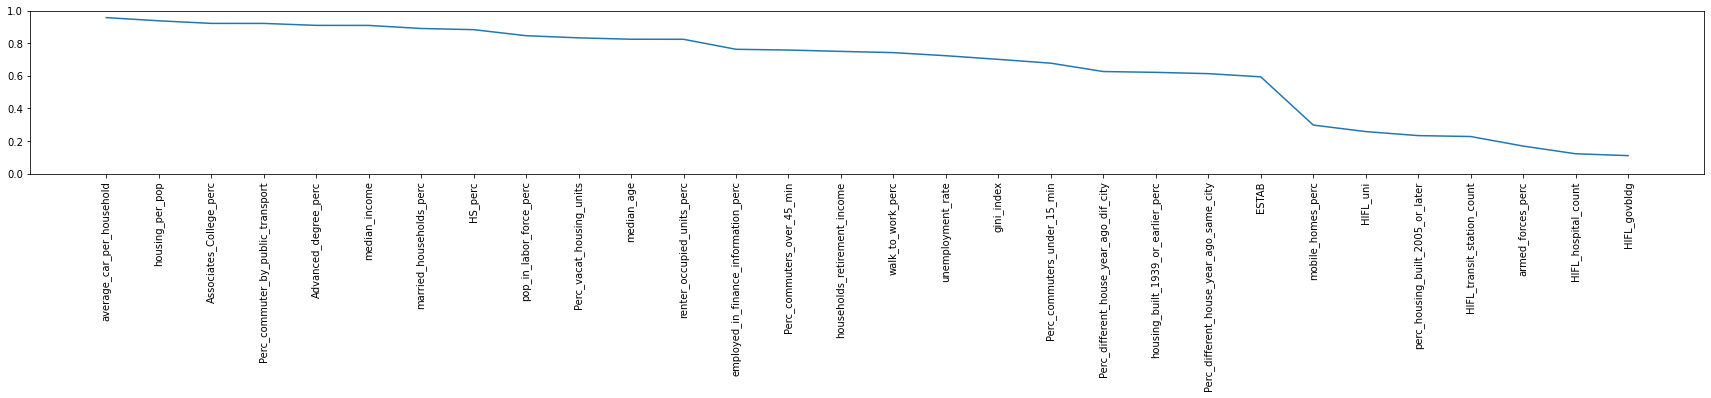

In [35]:
run_lasso_model_scaled(train_path, test_path, predict_path, 0, 2, 101, log_y=False, current_rent=False)

value of log_y: False
Fitting 5 folds for each of 101 candidates, totalling 505 fits
Best alpha:  0.8
Score on training data:  0.953
Scores from 5-fold cross-validation: 
 [0.9405177  0.93198692 0.94860142 0.95498903 0.96237505]
Score on TEST data (zip codes not trained on):  0.94
Score on PREDICT data (years not trained on):  0.823
RMSE for PREDICT data:  282.0630932171373
Total features:  34
Number of Features used:  30 

Used Features, sorted by importance:
('Current Rent', 614.047748178491)
('average_car_per_household', 101.95107140062785)
('renter_occupied_units_perc', 85.35051364650458)
('Advanced_degree_perc', -79.09903700887945)
('Associates_College_perc', 46.52989614296917)
('HS_perc', -41.5771871774189)
('Perc_commuter_by_public_transport', 34.59302828622744)
('walk_to_work_perc', 32.43837105136157)
('Perc_commuters_under_15_min', -28.83756673289661)
('median_age', 24.270417225490643)
('Perc_vacat_housing_units', 22.269317871255588)
('pop_in_labor_force_perc', -21.75618575933

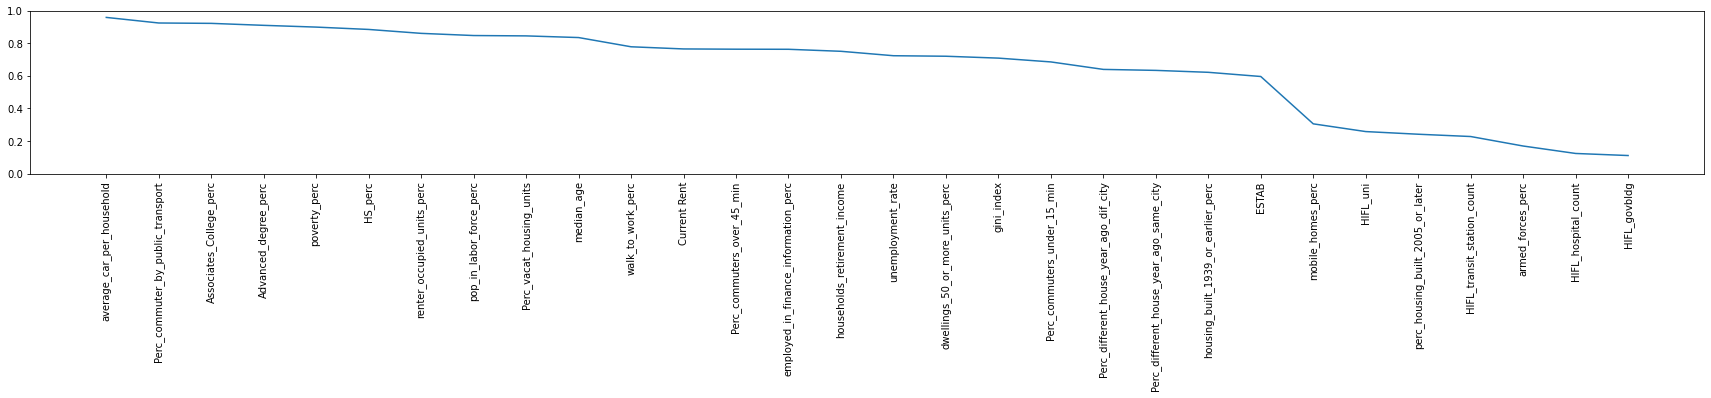

In [16]:
run_lasso_model_scaled(train_path, test_path, predict_path, 0, 1, 101, log_y=False, current_rent=True)

value of log_y: True
Fitting 5 folds for each of 101 candidates, totalling 505 fits
Best alpha:  0.00055
Score on training data:  0.76
Scores from 5-fold cross-validation: 
 [0.71987069 0.73078403 0.73171592 0.70243336 0.79085607]
Score on TEST data (zip codes not trained on):  0.702
Score on PREDICT data (years not trained on):  0.737
RMSE for PREDICT data:  0.2048237597325586
Total features:  33
Number of Features used:  32 

Used Features, sorted by importance:
('renter_occupied_units_perc', 0.26314152488247206)
('housing_per_pop', -0.22108371432829335)
('median_income', 0.2158035570133991)
('average_car_per_household', 0.20113665459348323)
('walk_to_work_perc', 0.14985416132963333)
('Perc_vacat_housing_units', 0.13850741119239646)
('median_age', 0.13119783510495492)
('Perc_commuter_by_public_transport', 0.08951361264404675)
('married_households_perc', -0.0883559103215183)
('Perc_different_house_year_ago_same_city', -0.07335828786967799)
('Associates_College_perc', 0.072634154044394

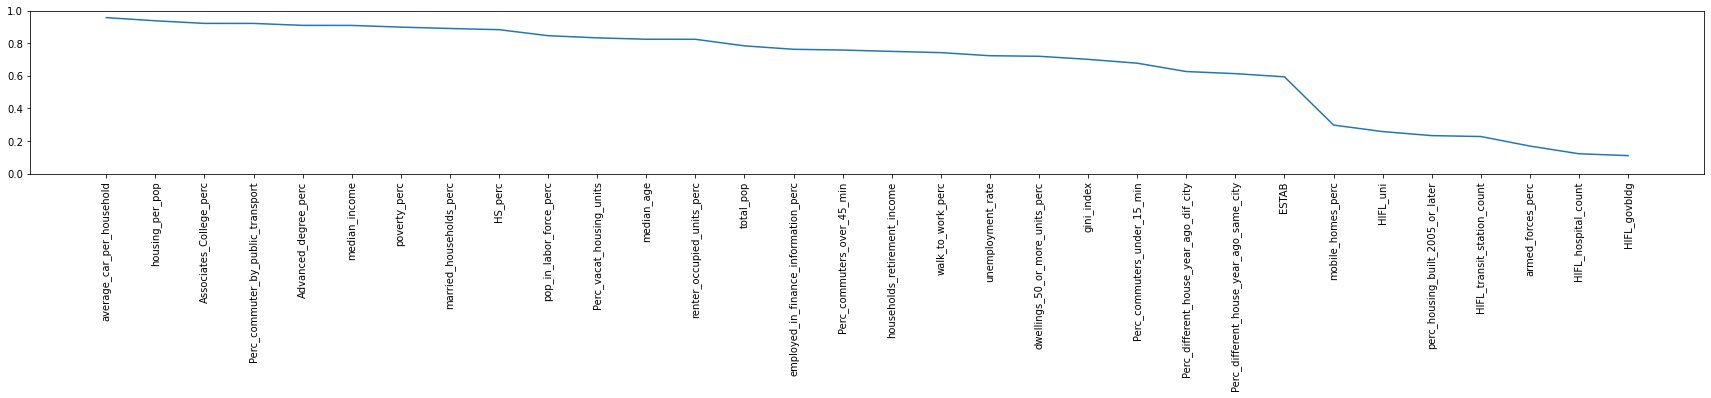

In [17]:
run_lasso_model_scaled(train_path, test_path, predict_path, 0, .001, 101, log_y=True, current_rent=False)

value of log_y: True
Fitting 5 folds for each of 101 candidates, totalling 505 fits
Best alpha:  0.00055
Score on training data:  0.919
Scores from 5-fold cross-validation: 
 [0.90080367 0.89447086 0.9089202  0.91877428 0.92619824]
Score on TEST data (zip codes not trained on):  0.912
Score on PREDICT data (years not trained on):  0.767
RMSE for PREDICT data:  0.19291751763951973
Total features:  34
Number of Features used:  31 

Used Features, sorted by importance:
('Current Rent', 0.3433457228077008)
('average_car_per_household', 0.07430724446826441)
('renter_occupied_units_perc', 0.06349707164015342)
('Perc_commuters_over_45_min', 0.06056989110951228)
('Associates_College_perc', 0.04986239972731457)
('Advanced_degree_perc', -0.04226844409381805)
('poverty_perc', -0.04124961104726279)
('HS_perc', -0.033588286535657104)
('housing_per_pop', -0.032914861974619306)
('median_age', 0.030084669327412814)
('Perc_vacat_housing_units', 0.025830251023993344)
('households_retirement_income', -0.

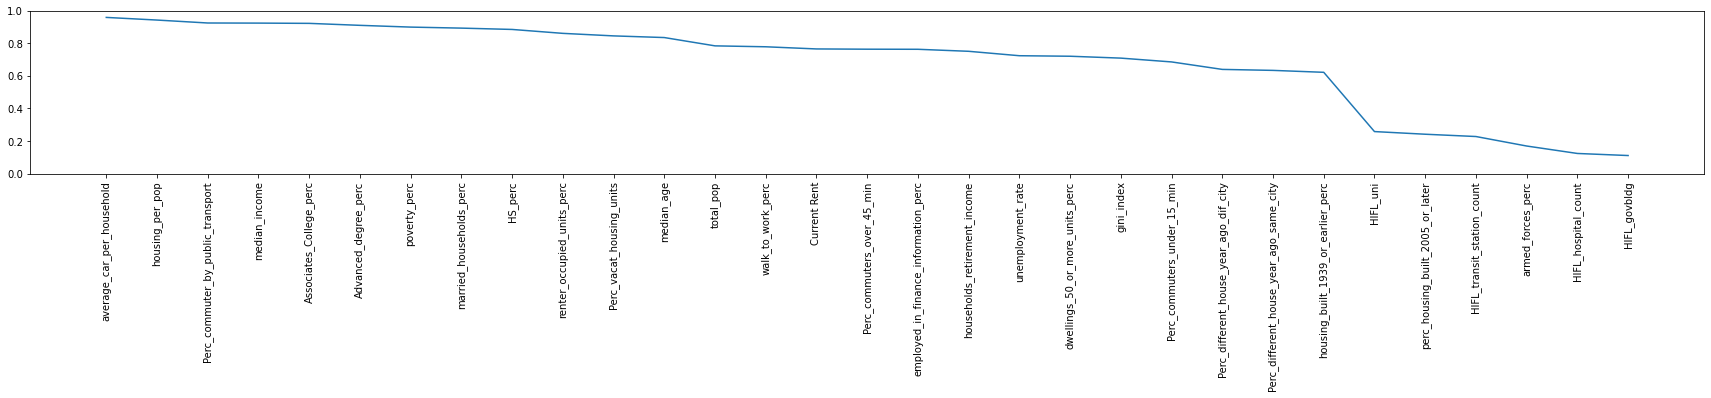

In [18]:
run_lasso_model_scaled(train_path, test_path, predict_path, 0, .001, 101, log_y=True, current_rent=True)

# Running My REVISED function on the PCA data

In [19]:
train_path = 'TRAINDATAnewcols7.19_3yearPCApartial.csv'
test_path = 'TESTDATAnewcols7.19_3yearPCApartial.csv'
predict_path = 'PREDICTDATAnewcols7.19_3yearPCApartial.csv'

value of log_y: No
Fitting 5 folds for each of 101 candidates, totalling 505 fits
Best alpha:  1.08
Score on training data:  0.951
Scores from 5-fold cross-validation: 
 [0.93777154 0.9287039  0.9451575  0.95498978 0.9602737 ]
Score on TEST data (zip codes not trained on):  0.936
Score on PREDICT data (years not trained on):  0.817
RMSE for PREDICT data:  286.8575295987964
Total features:  28
Number of Features used:  27 

Used Features, sorted by importance:
('2', 375.99048670866387)
('0', 356.16324023909857)
('7', -209.00340455436964)
('17', 200.64027668337104)
('21', 139.56490193430355)
('6', 100.74413543135648)
('8', 83.08257909393363)
('4', -79.55739140389232)
('15', 72.98587050490337)
('1', 64.89941745694824)
('11', -62.46796696590226)
('22', -57.90634931275086)
('13', 57.31880918554868)
('10', 49.73232266883093)
('9', -49.66736801296585)
('14', -43.32906837150062)
('27', 41.88284045811332)
('25', 36.17794727802876)
('16', 35.30433443318941)
('18', -31.99646436175256)
('5', -27.7

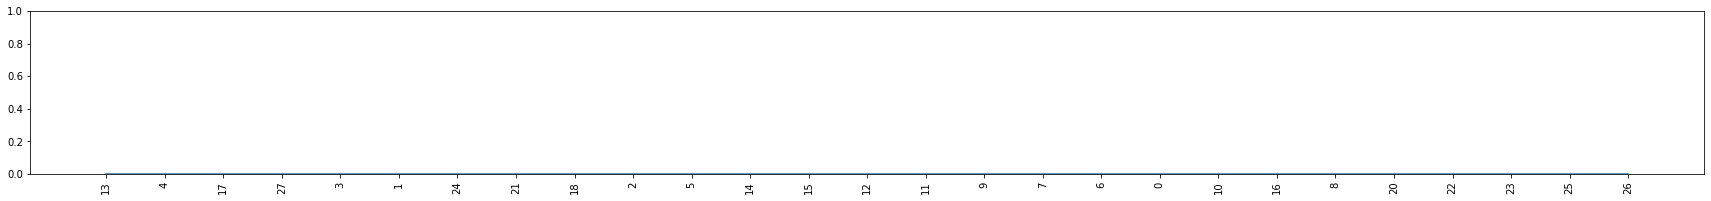

In [20]:
run_lasso_model_scaled(train_path, test_path, predict_path, 0, 2, 101, PCA_data=True)

In [21]:
train_path = 'TRAINDATAnewcols7.19_3yearPCApartial_nocurrentrent.csv'
test_path = 'TESTDATAnewcols7.19_3yearPCApartial_nocurrentrent.csv'
predict_path = 'PREDICTDATAnewcols7.19_3yearPCApartial_nocurrentrent.csv'

value of log_y: No
Fitting 5 folds for each of 101 candidates, totalling 505 fits
Best alpha:  0.92
Score on training data:  0.763
Scores from 5-fold cross-validation: 
 [0.69336345 0.73760791 0.73058439 0.72565767 0.80207547]
Score on TEST data (zip codes not trained on):  0.689
Score on PREDICT data (years not trained on):  0.739
RMSE for PREDICT data:  342.23634266226304
Total features:  33
Number of Features used:  33 

Used Features, sorted by importance:
('2', 365.9564239001331)
('0', 291.8224490834185)
('26', 130.89162858934228)
('8', 125.46571783212441)
('29', -109.7920271902783)
('19', 101.68353960025843)
('30', 101.65067900149353)
('17', 78.90867859070774)
('9', -75.44871521911486)
('4', -72.9983957763731)
('11', -70.78968604885816)
('1', 68.40379465943113)
('10', 66.47660931471141)
('32', 63.55627693805147)
('23', 62.56740980312573)
('25', 56.4046061588644)
('31', -54.709499445546015)
('6', 54.59965489897496)
('18', -50.0152018372682)
('7', -49.20800835546941)
('13', 45.1618

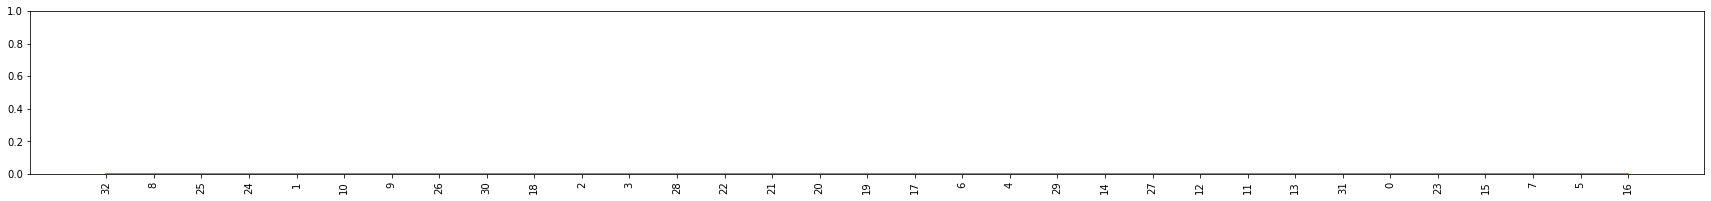

In [22]:
run_lasso_model_scaled(train_path, test_path, predict_path, 0, 4, 101, PCA_data=True)

In [31]:
# Just Current Rent model (aka null model when including rent):
# Load the data

data = pd.read_csv('TRAINDATAnewcols7.19_3year.csv', index_col=False)
test_data = pd.read_csv('TESTDATAnewcols7.19_3year.csv', index_col=False)
predict_data = pd.read_csv('PREDICTDATAnewcols7.19_3year.csv', index_col=False)       

# Create feature
train_X = data[['Current Rent']]
test_X = test_data[['Current Rent']]
predict_X = predict_data[['Current Rent']]

# Create target
train_y = data['Rent']
test_y = test_data['Rent']
predict_y = predict_data['Rent']

    
# Create and fit the model
lasso = Lasso(normalize=False, max_iter=1000)
lasso_params = {'alpha':np.linspace(0, 10000, 100)}
grid_lasso = GridSearchCV(lasso, lasso_params, scoring='r2', n_jobs=-1, cv=5, verbose=2)
grid_lasso.fit(train_X, train_y)
    
# Tell user alpha used
print('Best alpha: ', grid_lasso.best_params_['alpha'])
    
# Tell user training score
print('Score on training data: ', round(grid_lasso.score(train_X,train_y),3))
    
# Tell user the cross-validation scores
print('Scores from 5-fold cross-validation: \n', cross_val_score(grid_lasso, train_X, train_y, scoring='r2', n_jobs=-1, cv=5))
    
# Tell user the test score (for zip codes not seen)
print('Score on TEST data (zip codes not trained on): ', round(grid_lasso.score(test_X,test_y),3))
    
# Tell the user the Prediction score (for future years not seen)
print('Score on PREDICT data (years not trained on): ', round(grid_lasso.score(predict_X,predict_y),3))
    
# RMSE for prediction NO MODEL
print('RMSE for PREDICT data: ', mean_squared_error(predict_y, predict_X, squared=False))
print('R^2 for PREDICT data: ', r2_score(predict_y, predict_X))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best alpha:  202.02020202020202
Score on training data:  0.935
Scores from 5-fold cross-validation: 
 [0.92436458 0.92037355 0.9351734  0.9395099  0.95103012]
Score on TEST data (zip codes not trained on):  0.921
Score on PREDICT data (years not trained on):  0.82
RMSE for PREDICT data:  212.51205217210602
R^2 for PREDICT data:  0.899379018627382


# Maybe go log price??

In [ ]:
plt.hist(y, bins=500)
plt.xlim(0,5000)
plt.title('Rental Index by Zip Code. There is an unshown outlier at 17k')
plt.show()

In [ ]:
plt.hist(np.log(y), bins=100)
plt.title('ln(Rental Indox) by Zip Code')
plt.show()

## What is an outlier?

In [ ]:
len(y[y>3500])

In [ ]:
len(y)

In [ ]:
np.std(np.log(y))

In [ ]:
np.mean(np.log(y))

In [ ]:
np.mean(np.log(y)) + 3*np.std(np.log(y))

In [ ]:
np.exp(np.mean(np.log(y)) + 3*np.std(np.log(y)))